Install libraries

In [1]:
!pip install datasets
!pip install keras
!pip install keras-self-attention

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      

Import libraries

In [2]:
#LSTM for multi-categorical classification
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from keras_self_attention import SeqSelfAttention
import random

Set constants/parameters

In [3]:
vocab_size = 10000
embedding_dim = 64
max_length = 30
trunc_type = 'post'
padding_type = 'post'

Login to huggingface to import dataset

In [4]:
from huggingface_hub import notebook_login
import datasets
from datasets import load_dataset
notebook_login()

Import dataset

In [5]:
dataset = load_dataset("toxigen/toxigen-data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/940 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8960 [00:00<?, ? examples/s]

Filter and preprocess dataset


In [17]:
#preprocessing for balanced dataset
#number of rows that are the smaller categories is around 350
smaller_categories = ['disagreement', 'uses positive stereotyping', 'maybe uses positive stereotyping']
bigger_category = 'doesn\'t use positive stereotyping'

smaller_cat_ds = dataset['train'].filter(lambda example: example['stereotyping'] in smaller_categories)
print(smaller_cat_ds)
bigger_cat_ds = dataset['train'].filter(lambda example: example['stereotyping'] == bigger_category)
print(bigger_cat_ds)
index = np.random.randint(dataset['train'].num_rows, size=smaller_cat_ds.num_rows)
sampled = dataset['train'].select(index)
print(sampled)

text_ds = datasets.concatenate_datasets([smaller_cat_ds, sampled])
text_ds = text_ds.shuffle(seed=42)
print(text_ds)
print(text_ds[0])


smaller_cat_ds = dataset['test'].filter(lambda example: example['stereotyping'] in smaller_categories)
print(smaller_cat_ds)
bigger_cat_ds = dataset['test'].filter(lambda example: example['stereotyping'] == bigger_category)
print(bigger_cat_ds)
index = np.random.randint(dataset['test'].num_rows, size=smaller_cat_ds.num_rows)
sampled = dataset['test'].select(index)
print(sampled)

validation_ds = datasets.concatenate_datasets([smaller_cat_ds, sampled])
validation_ds = validation_ds.shuffle(seed=42)
print(validation_ds)
print(validation_ds[0])

Dataset({
    features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
    num_rows: 505
})
Dataset({
    features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
    num_rows: 8455
})
Dataset({
    features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
    num_rows: 505
})
Dataset({
    features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
    num_rows: 1010
})
{'text': "i wish that i could visit mexico more often, it'

In [18]:
#setting text and label lists
text_list = text_ds[:]['text']
label_list = np.array([0 if i in smaller_categories else 1 for i in text_ds[:]['stereotyping']])
print(text_list)
print(text_ds[0]['stereotyping'])
print(label_list[0])
print(len(text_list))
print(len(label_list))

validation_text_list = validation_ds[:]['text']
validation_label_list = np.array([0 if i in smaller_categories else 1 for i in validation_ds[:]['stereotyping']])
print(validation_text_list[0])
print(validation_ds[0]['stereotyping'])
print(validation_label_list[0])
print(len(validation_text_list))
print(len(validation_label_list))

["i wish that i could visit mexico more often, it's so beautiful. \\\\r- i love the idea of guacamole.", 'the food that you eat is so delicious and i wish that i could have some right now', 'in fact, there is no scientific basis for the belief that homosexuality is a mental disorder.', 'the vast majority of asians are not chinese', "iran is not a terrorist country, it's a country that has been demonized by the west  ", 'there is a lot of great food to eat, especially if you are vegetarian or vegan', 'the middle east is boring', 'a system of connections between different compartments', 'it is the latest smartphone from samsung', 'chinese immigrants were instrumental in the building of the transcontinental railroad in the 1860s, and the construction of the golden gate bridge in the 1930s', 'the chinese are taking over the country-\\nwe need to kill all the chinese in america before they take over the world. there used', 'asian american pianist deborah chin, who herself faced prejudice as

Processing data

In [19]:
#text vectorization

#custom standardization not needed
# REPLACE_BY_SPACE_RE = '[/(){}\[\]\|@,;]'
# BAD_SYMBOLS_RE = '[^0-9a-z #+_]'

# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   tf.strings.regex_replace(lowercase, REPLACE_BY_SPACE_RE, " ")
#   tf.strings.regex_replace(lowercase, BAD_SYMBOLS_RE, "")
#   return lowercase

sequence_length = 20

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length)

In [20]:
#vectorize text data
vectorize_layer.adapt(text_list)
train_padded = vectorize_layer(text_list)

In [21]:
validation_padded = vectorize_layer(validation_text_list)

Validating data structure

In [23]:
#Verifing tokenization
#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_text(text):
    return ' '.join([vectorize_layer.get_vocabulary()[i] for i in text])

print('Training Example')
print(train_padded[100])
print(train_padded.numpy()[100])
print(decode_text(train_padded[100]))
print(text_list[100])
print(label_list[100])

print('Validation Example')
print(validation_padded[9])
print(decode_text(validation_padded[9]))
print(validation_text_list[9])
print(validation_label_list[9])

Training Example
tf.Tensor(
[  2  59 107  15  47  16 381  25  56   9  15  14   7  72  38  37  43  14
  29   6  14  29  17 157  79 368 228   0   0   0], shape=(30,), dtype=int64)
[  2  59 107  15  47  16 381  25  56   9  15  14   7  72  38  37  43  14
  29   6  14  29  17 157  79 368 228   0   0   0]
the only thing that can be said for them is that they are very good at what they do and they do it better than anyone else   
the only thing that can be said for them is that they are very good at what they do, and they do it better than anyone else
1
Validation Example
tf.Tensor(
[ 19   9  45 111 107  23 482 320  71  18  24  19   9 111 107  23 482 320
 105  18  24  19   9  45 111 107  23 482   0   0], shape=(30,), dtype=int64)
there is no such thing as racism against white people but there is such thing as racism against black people but there is no such thing as racism  
 there is no such thing as racism against white people, but there is such thing as racism against black people, but the

In [24]:
#Checking for no null values
print(not np.any(np.isnan(train_padded)))
print(not np.any(np.isnan(label_list)))
print(not np.any(np.isnan(validation_padded)))
print(not np.any(np.isnan(validation_label_list)))

True
True
True
True


Building and training model

In [25]:
#Bi directional LSTM model with self-attention layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    SeqSelfAttention(attention_activation='sigmoid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention_1                 │ ?                           │     0 (unbuilt) │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
#Training
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 4
history = model.fit(train_padded.numpy(),label_list, epochs=num_epochs, validation_data=(validation_padded.numpy(), validation_label_list), verbose=2)


Epoch 1/4
32/32 - 4s - 114ms/step - accuracy: 0.5376 - loss: 0.6900 - val_accuracy: 0.6111 - val_loss: 0.6767
Epoch 2/4
32/32 - 1s - 26ms/step - accuracy: 0.7257 - loss: 0.5253 - val_accuracy: 0.6349 - val_loss: 0.6793
Epoch 3/4
32/32 - 1s - 23ms/step - accuracy: 0.8366 - loss: 0.3937 - val_accuracy: 0.6190 - val_loss: 0.6740
Epoch 4/4
32/32 - 0s - 14ms/step - accuracy: 0.9059 - loss: 0.2500 - val_accuracy: 0.6270 - val_loss: 0.8258


Predictions and validation

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 30, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention_1                 │ (None, 30, 128)             │           8,257 │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           3,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,154,440 (8.22 MB)

 Trainable params: 718,146 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,436,294 (5.48 MB)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


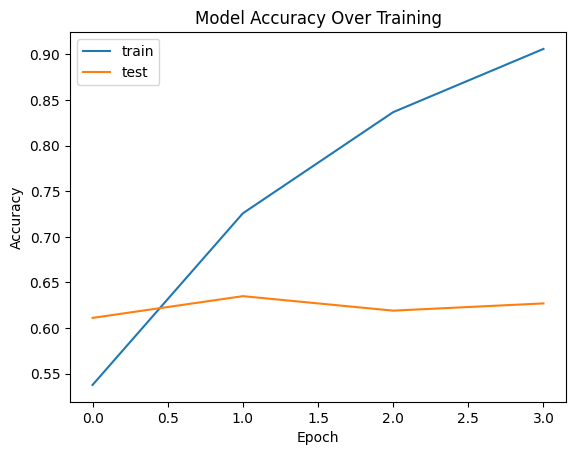

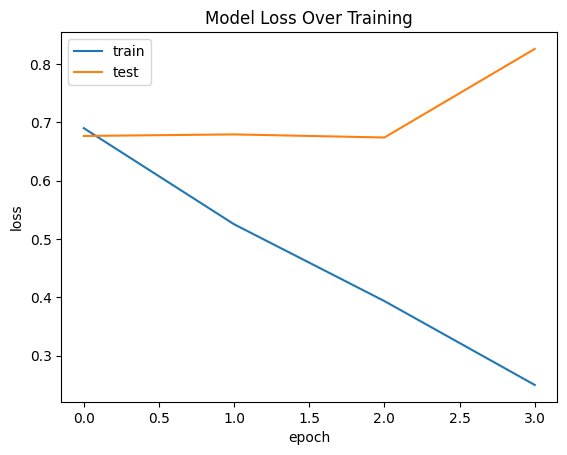

In [27]:
#Training Results
from sklearn.metrics import confusion_matrix
import csv

model.summary()

# list all data in history
print(history.history.keys())

#Accurary
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Over Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# 0 is negative
#1 is positive/neutral

#Testing prediction
txt = ["I find her really aggressive, I wish she'd tone it down."]
seq = vectorize_layer(txt)
padded = pad_sequences(seq, maxlen=max_length, padding = 'post')
print(decode_text(padded[0]))
pred = model.predict(padded)
print(pred)
print(0 if pred < 0.5 else 1)


i find her really [UNK] i wish [UNK] tone it down                   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
[[0.01903897]]
0
